#  Demo: Loess and Lowess operators applied to 1-d timeseries 

+ author  : Stephanie Leroux, Ocean Next /  MEOM/IGE
+ date    : Oct 2017
+ purpose : Demonstration of how to use: 
            - the loess operator from R package for python.
            - the lowess operator from statsmodels python package (inspired by Sally's code).
+ *[Extra packages]*:  Extra packages to install: rpy2 (via conda) and statsmodels (via conda)


# Loess:
* It's a nonparametric fitting method: local polynomial regression (degree 2 by default)
* It's based on rpy2 package (R in Python)
* See for example ```https://www.statsdirect.com/help/nonparametric_methods/loess.htm```

###  1. Define a LOESS detrending function `loess_detrend()` based on  the R package for python:

In [4]:
#import math
import numpy as np
#import numpy.fft as fft
#import numpy.ma as ma
#from scipy.stats import sem
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
# Since rpy2 version 2.3, it is necessary to activate the automatic 
# conversion from numpy to R arrays
if hasattr(rpy2.robjects.numpy2ri, 'activate'):
   rpy2.robjects.numpy2ri.activate()

################################################
################################################
def loess_detrend(ts, time, wgts, span=0.99, degree=2):
    """ non-linear loess detrending inspired from Guillaume Serrazin's tools
        Uses R package for Python
        This loess filter is set for parameters (spann 0.99, degree=2) that
        are equivalent to a HP filter of cutoff period = half the total time-segment.
        
        Note: wgts is a vector containing the weights to apply on the operator for each time-step. T
        he normal usage is to set wgts to 0.   Ex:  wgts = np.ones(len(data) ). But sometimes you might
        need to impose that the first time step of the timeseries (data[0]) should be invariant through 
        the loess operator. In that case, just set the first weight to a high number. Ex: wgts[0]=1000.  
    """
    rloess = robjects.r['loess']
    fmla = robjects.Formula('y ~ x')
    env = fmla.environment
    env['x'] = time
    env['y'] = ts
    ts_dtr = np.array(rloess(fmla, span=span, degree=degree, weights=wgts)[2])
    return ts_dtr
 


### 2. Create synthetic data and plot

In [84]:
datatssynthetic1 = np.zeros(56)
datatssynthetic2 = np.zeros(56)
datatssynthetic4 = np.zeros(56)
noise = np.random.normal(0, 0.1, 56)

for i in range(0,56):
    datatssynthetic1[i]=np.sin(np.pi*i/56)
    datatssynthetic2[i]=np.sin(2*np.pi*i/56)
    datatssynthetic4[i]=0.2*np.sin(20*np.pi*i/56)
datatssynthetic4 = datatssynthetic4 + noise
datatssynthetic5 = datatssynthetic2+datatssynthetic4
datatssynthetic6 = datatssynthetic1+datatssynthetic4

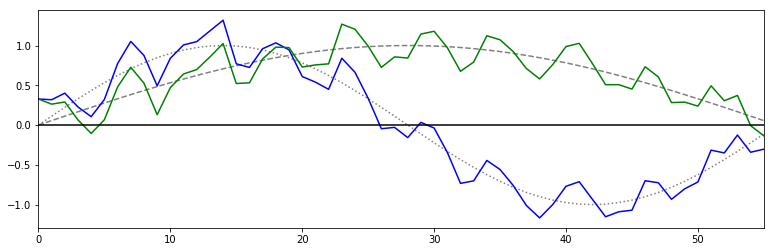

In [85]:
# plot
fig2 = plt.figure(figsize=([13,4]),facecolor='white')        
plt.plot(datatssynthetic1,color='grey',linestyle='--')
plt.plot(datatssynthetic2,color='grey',linestyle=':')
plt.plot(datatssynthetic5,color='b',linestyle='-')
plt.plot(datatssynthetic6,color='g',linestyle='-')

plt.plot(datatssynthetic6*0.,color='k',linestyle='-')


plt.xlim(0,datatssynthetic1.shape[0]-1)

plt.show()   

### 3. Apply the Loess detrending operator (degree 2 span 0.99) and plot:

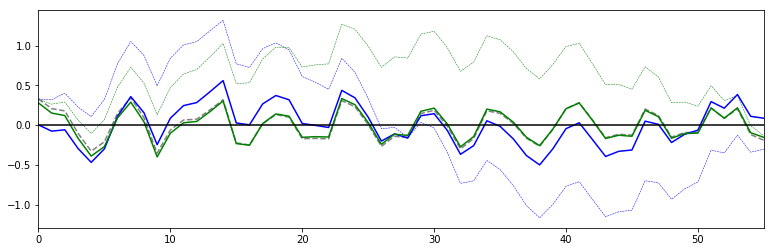

In [89]:
# Set all weights to 0
wgts = np.ones(datats.shape[0])   


# Apply the loess detrending operator:
datas5_dt = loess_detrend(datatssynthetic5, \
                   np.array(range(0,datats.shape[0],1)), wgts, \
                   span=0.99, degree=2) 

datas6_dt = loess_detrend(datatssynthetic6, \
                   np.array(range(0,datats.shape[0],1)), wgts, \
                   span=0.99, degree=2) 

# plot
fig2 = plt.figure(figsize=([13,4]),facecolor='white')        

# high frequency var without any trend
plt.plot(datatssynthetic4,color='grey',linestyle='--')

# A: high frequency + T=1*windows trend
plt.plot(datatssynthetic5,color='b',linestyle='--',linewidth=0.5)

# B: high frequency + T=2*windows trend
plt.plot(datatssynthetic6,color='g',linestyle='--',linewidth=0.5)

# detrended from A
plt.plot(datas5_dt,color='b',linestyle='-')

# detrended from B
plt.plot(datas6_dt,color='g',linestyle='-')

# plot y=0 line in black
plt.plot(datas6_dt*0.,color='k',linestyle='-')

# x axis range
plt.xlim(0,datatssynthetic1.shape[0]-1)

plt.show()   

### Conclusion Loess:
* Detrending by removing the loess fit set to degree 2 and span 0.99 removes periods of variability larger than the timeseries window almost entirely.
* Small resdual trend for blue curves (T=1-window).

# Lowess
* It's a linear local regression fit (degree 1)
* Based on python package statsmodels
* See: ```http://www.statsmodels.org/devel/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html```

### 1. Define Sally's ```getspline``` function and plot detrended timeseries

In [87]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.interpolate as spi
def getspline(x,jd):
    smth=lowess(x,jd,25.0/55)
    fn=spi.UnivariateSpline(jd,smth[:,1],k=5,ext=0)
    return smth[:,1],fn

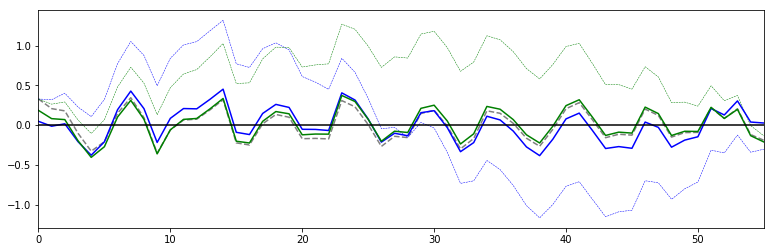

In [88]:
# apply Lowess function (and gets smoothed trend)
jd = range(0,56)
datas5_tr=getspline(datatssynthetic5,jd)[0]
datas6_tr=getspline(datatssynthetic6,jd)[0]

# compute detrended data (remove trend from data)
datas5_dt = datatssynthetic5 - datas5_tr
datas6_dt = datatssynthetic6 - datas6_tr
    
# plot
fig2 = plt.figure(figsize=([13,4]),facecolor='white')        

# high frequency var without any trend
plt.plot(datatssynthetic4,color='grey',linestyle='--')

# A: high frequency + T=1*windows trend
plt.plot(datatssynthetic5,color='b',linestyle='--',linewidth=0.5)

# B: high frequency + T=2*windows trend
plt.plot(datatssynthetic6,color='g',linestyle='--',linewidth=0.5)

# detrended from A
plt.plot(datas5_dt,color='b',linestyle='-')

# detrended from B
plt.plot(datas6_dt,color='g',linestyle='-')

# plot y=0 line in black
plt.plot(datas6_dt*0.,color='k',linestyle='-')

# x axis range
plt.xlim(0,datatssynthetic1.shape[0]-1)

plt.show()   

### Conclusion Lowess:
* Detrending by removing the lowess fit (linear local regression): removes periods of variability larger than the timeseries window almost entirely.
* Small residual trend for blue curves (T=1-window) but smaller than when using Loess fit above.